# Beispiel für Datenzugriff auf eLabFTW

pyelabdata ist ein Modul, das den einfachen Datenzugriff (lesen/schreiben) auf ELN-Einträge ermöglicht. Dabei wurden bislang die folgenden typischen Szenarien berücksichtigt, wie sie im physikalischen Praktikum vorkommen können:
* Lesen von Tabellendaten (spaltenweise erfasste Daten) aus dem Haupttext des ELN-Eintrags
* Lesen von csv-Dateien, die in einem ELN-Eintrag als Anhang gespeichert wurden
* Speichern und lesen von Werten in Extra Fields in einem ELN-Eintrag
* Hochladen von lokalen Dateien in einen ELN-Eintrag
* Hochladen von Bilddateien von Diagrammen, die mittels matplotlib erzeugt wurden
* Hochladen von numerischen Daten als csv-Datei
* Speichern und hochladen des aktuellen Jupyter-Notebooks

In [ ]:
import pyelabdata as eln
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
from PIL import Image
from io import BytesIO
from IPython.display import display

### Verbindung mit eLabFTW
Zunächst wird eine Verbindung zum eLabFTW-Server über die Server-URL und einen API-Key hergestellt.

In [2]:
API_HOST_URL = 'https://your_server_url/api/v2'
API_KEY = 'your_apikey'

In [3]:
eln.connect(API_HOST_URL, API_KEY)

### Experiment öffnen
Jetzt wird ein Experiment anhand der Experiment-ID in eLabFTW geöffnet; alle nachfolgenden Kommandos wirken auf dieses Experiment, es sei denn es wird ein anderes Experiment explizit über den Parameter expid=xxx spezifiziert. Die Rückgabe enthält ein Dictionary mit den Metadaten des Experiments.

In [4]:
# In diesem Beispiel wird das Experiment mit der ID 123 geöffnet.
eln.open_experiment(123)

### Tabellendaten aus dem Haupttext eines ELN-Eintrags laden
Ohne weitere Parameter wird die erste Tabelle im Haupttext abgerufen.

In [5]:
data = eln.get_table_data()
print(data)

{'U (V)': array([1., 2., 3., 4.]), 'I (mA)': array([ 5., 11., 14., 20.]), nan: array([nan, nan, nan, nan]), 'U (V)_1': array([100., 101., 102., 103.])}


Die Datenausgabe ist standardmäßig ein dictionary der Datenspalten, wobei die keys (Namen) der Spalten aus der ersten Tabellenzeile extrahiert werden. Alternativ kann auch über den Parameter datatype='df' ein pandas.DataFrame zurückgegeben werden.

Beispiel für die Visualisierung der Daten:

Text(0, 0.5, 'I (mA)')

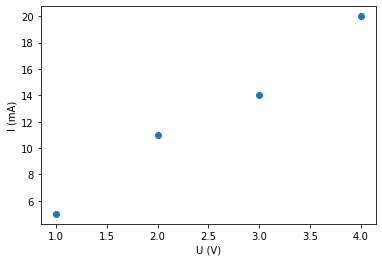

In [6]:
fig, ax = plt.subplots()
ax.scatter(data['U (V)'], data['I (mA)'])
ax.set_xlabel('U (V)')
ax.set_ylabel('I (mA)')

### Speichere Daten in einem Extra Field im ELN-Eintrag
Wir bestimmen den ohmschen Widerstand aus der linearen Regression der Messdaten und speichern das Ergebnis im ELN-Eintrag in einem neuen Extra Field "R" in der Extra Field Gruppe "Ergebnisse".

In [ ]:
result = linregress(data['U (V)'], data['I (mA)'])
R = 1 / result.slope * 1000
print(f'Widerstand R = {R:.0f} Ohm')

In [ ]:
eln.create_extrafield('R', R, fieldtype='number', unit='Ohm', 
                      description='Elektrischer Widerstand bestimmt aus Messdaten durch lineare Regression',
                      groupname='Ergebnisse')

In [ ]:
# Der Wert aus dem Extra Field kann auch wieder aus dem ELN gelesen werden
value = eln.get_extrafields('R')
print(f'Wert des Extra Fields "R": {value}')

### csv-Datei aus ELN-Eintrag laden
Hierfür wird der Dateiname benötigt. Die Datenausgabe ist analog zu get_table_data().

In [7]:
data = eln.get_file_csv_data('testdata.txt')
print(data)

{'t(s)': array([0., 1., 2., 3., 4., 5., 9.]), 'U(V)': array([1., 2., 4., 6., 7., 8., 8.])}


Text(0, 0.5, 'U (V)')

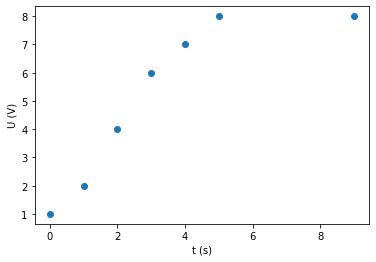

In [8]:
fig, ax = plt.subplots()
ax.scatter(data['t(s)'], data['U(V)'])
ax.set_xlabel('t (s)')
ax.set_ylabel('U (V)')

### Upload von matplotlib Diagrammen in einen ELN-Eintrag
Für den Upload werden das matplotlib Figure-Objekt sowie ein Dateiname und ein Kommentar (Bildbeschreibung) benötigt.

Standardmäßig werden existierende Abbildungen mit gleichem Dateinamen überschrieben. Mit dem Parameter replacefile=False kann das Überschreiben deaktiviert werden; es wird dann mit jedem Upload ein neuer Bildanhang erstellt.

In [9]:
eln.upload_image_from_figure(fig, 'testdata_plot.png', 'This is a diagram of the data contained in testdata.txt.')

### hdf5-Datei aus ELN-Eintrag laden
Hierfür wird der Dateiname benötigt. Die Ausgabe ist ein h5py file object, wie es durch h5py.File erzeugt wird.

In [ ]:
hdf5file = eln.get_file_hdf5_data('data.nxs')

# hdf5 ist ein hierarchisches Dateiformat. Wir geben hier alle Schlüssel der Root-Ebene aus.
keys = hdf5file.keys()
list(keys)

In [ ]:
# Wir laden die Daten aus dem ersten Eintrag; diese sind im Abschnitt data/IV_sweep gespeichert.
experiment = hdf5file[list(keys)[0]]
dataset = experiment['data/IV_sweep']

temperatures = np.unique(np.array(dataset['PID_setpoint']))
data = [
    {
        'setpoint': temp,
        'temperature_avg': np.average(dataset['PID_current_value'][np.where(dataset['PID_setpoint'] == temp)]),
        'voltage': np.array(dataset['SMU_mesV1'][np.where(dataset['PID_setpoint'] == temp)]),
        'current': np.array(dataset['SMU_mesI1'][np.where(dataset['PID_setpoint'] == temp)]),
    }
    for temp in temperatures
]
print(data)

### Lese den (binären) Inhalt einer Datei aus dem ELN
In diesem Beispiel lesen wir eine Bilddatei ein und zeigen das Bild.

In [ ]:
filedata = eln.get_file_data('testdata_plot.png')

# Wir nutzen BytesIO, um aus den binären Daten einen Filestream zu erstellen, der mit Image.open gelesen werden kann.
display(Image.open(BytesIO(filedata)))

### Upload von numerischen Daten als csv-Datei in einen ELN-Eintrag
Für den Upload wird die ID des ELN-Eintrags benötigt, in dem die csv-Datei erstellt werden soll. Die Upload-Funktion kann eine csv-Datei aus einem DataFrame oder einem Dictionary aus Spaltendaten (numpy arrays) erzeugen; im letzteren Fall, werden die Keys als Spaltenüberschrift verwendet (siehe folgendes Beispiel).

In [11]:
# Wir erzeugen uns zunächst ein Testsignal (Sinusspannung mit einer Amplitude von 1 V und einer Frequenz von 4 Hz,
# 101 Datenpunkte über den Zeitraum von 1 s abgetastet).
t = np.linspace(0, 1, 101)
U = np.sin(2 * np.pi * 4 * t)

# Upload nach eLabFTW
eln.upload_csv_data({'t (s)': t, 'U (V)': U}, 'voltage_sine.txt', 'A sine voltage with frequency of 4 Hz.')

### Save and upload this jupyter notebook in einen ELN-Eintrag
Für den Upload dieses Jupyter-Notebooks wird lediglich die ID des ELN-Eintrags benötigt, in den die Datei geladen werden soll sowie eine Beschreibung.

DIESE FUNKTION FUNKTIONIERT ZUR ZEIT NOCH NICHT!!!

In [12]:
eln.upload_this_jupyternotebook('This is the jupyter notebook that generated the evaluated data and uploads.')

<IPython.core.display.Javascript object>

### Trennung der Verbindung zum eLabFTW-Server

In [11]:
eln.disconnect()